In [71]:
# Grover's: Quantum vs. Classical Search

print("Today we're doing a live race.")

print("Story: there's a locked box that opens only if you guess a secret 4-bit code. Think something like 1010.")

print("Team Classical will try to break the code by brute force.")

print("Team Quantum will try to break the code using Grover's algorithm, which is a quantum search routine.")

print("-The point of this is not just haha quantum faster. The point is:")
print("-Searching for the right answer inside a huge space is actually what we do in machine learning all the time. We spend all of training trying to find good parameters.")
print("- Grover's algorithm is literally built to speed up that kind of search.")
print("- So this matters for quantum machine learning because if you can speed up the search for good parameters, you might be able to speed up training.")

print("Agenda:")
print("1. Set up the problem and pick a secret 4-bit code (this is the password).")
print("2. Classical brute-force search.")
print("3. Quantum Grover search.")
print("4. Visualize how Grover amplifies the correct answer.")
print("5. Talk about how this connects to machine learning and optimization.")
print("6. Answer the question: Does quantum beat everything, including neural networks? (Short answer: no, and I'll explain why.)")


Today we're doing a live race.
Story: there's a locked box that opens only if you guess a secret 4-bit code. Think something like 1010.
Team Classical will try to break the code by brute force.
Team Quantum will try to break the code using Grover's algorithm, which is a quantum search routine.
-The point of this is not just haha quantum faster. The point is:
-Searching for the right answer inside a huge space is actually what we do in machine learning all the time. We spend all of training trying to find good parameters.
- Grover's algorithm is literally built to speed up that kind of search.
- So this matters for quantum machine learning because if you can speed up the search for good parameters, you might be able to speed up training.
Agenda:
1. Set up the problem and pick a secret 4-bit code (this is the password).
2. Classical brute-force search.
3. Quantum Grover search.
4. Visualize how Grover amplifies the correct answer.
5. Talk about how this connects to machine learning and o

In [72]:
# Grover's Escape Room: Quantum vs. Classical Search

# Context of what we're doing today:

# You are all locked in a fake bunker (mentally). The only way to "get out" is to guess a 4-bit code. Example of a 4-bit code would be `1010`. Four bits = four binary digits. That means 16 possible codes total, from `0000` up to `1111`.

# Here's how we're going to run this:

# - Classical Team:
  # - You will try to brute-force the code by guessing possibilities one at a time.
  # - This is literally what brute force password cracking looks like if you’re not doing anything clever.

# - Quantum Team:
  # - We’re going to run an algorithm called Grover’s algorithm.
  # - Instead of guessing codes one by one, Grover boosts the correct answer’s probability so high that when we "measure" once, that one shot is very likely to already be the correct code.

# At the end, we compare: did we do fewer tries (quantum) than classical? Answer should be yes, and in a stronger way than "just faster computer." It's mathematically fewer tries as the space gets bigger.

# Why I'm showing you this (this is what matters for QML, not just the trick):
# - Training a machine learning model (like tuning weights in a neural network) is basically one giant search for parameters that don't suck.
# - Grover is literally an algorithm that speeds up search.
# - If you can speed up search, you can potentially speed up learning.
# - This is why quantum machine learning is a thing and not just hype words.

# What we will cover in order:
# 1. We secretly choose a code.
# 2. We look at how classical brute force behaves.
# 3. We build Grover’s quantum search and inspect how it behaves.
# 4. We plot the probability spike so you can literally see one answer dominate.
# 5. We explain why that matters for machine learning and optimization.

# Ground rules for the demo:
# - I already loaded the secret in the notebook in a cell you are not supposed to scroll down to look at the THIRD CELL
# - Don't scroll to the third cell. If you scroll up and read it, congratulations, you ruined the game and also outed yourself as That Person.
# - I will check guesses myself locally and I’ll tell you when someone hits it.


In [73]:
# ADMIN / PRESENTER CELL
# DO NOT SCROLL UP IF YOU'RE IN THE ROOM WATCHING THIS
# I'm serious. Don't ruin the game.

# Pick any 4-bit string. Change it live if you want.
SECRET_CODE = "1011"  # I will change this if you read so please do not!!!

# number of qubits is just the length of the code
n_qubits = len(SECRET_CODE)

# Convert secret bitstring ("1010") to an integer index (10)
target_index = int(SECRET_CODE, 2)

print("Secret loaded.")
print("Number of qubits:", n_qubits)
print("Search space size:", 2 ** n_qubits, "possible codes")

# IMPORTANT:
# After this cell runs, I am not going to re-print SECRET_CODE anywhere.
# Please don't scroll back up to cheat.

Secret loaded.
Number of qubits: 4
Search space size: 16 possible codes


In [74]:
!pip install pennylane matplotlib --quiet

In [75]:
#Imports as always
import itertools
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as pnp

print("Libraries are now ready :)")



Libraries are now ready :)


In [76]:
## Classical brute force strategy

# Let's talk about how classical guessing works.

# If you don't know the code, you just guess something like `0101`, then you check. If it's wrong, you guess `0000`, then check. Repeat.

# That's literally brute force. There is no intelligence in it. It's just: generate candidate → test → repeat.

# For a 4-bit code:
# - There are 16 possible codes.
# - Worst case, you might have to try all 16.

# For a 40-bit code:
# - There are 2^40 possibilities.
# - 2^40 is over a trillion.
# - You are not doing that by hand, and it's not instant anymore.

# Now we write a little helper that simulates a classical brute force attacker.
# It doesn't know the answer. It just tries everything in some order.
# We’ll save that order, because that's what our "Classical Team" will basically act out in the room.


In [77]:
def classical_bruteforce_attempts(num_bits, reveal_order=False):
    """
    Simulate classical brute force.

    num_bits: number of bits in the code (here it's 4).
    reveal_order: if True, we'll print each guess in the order we'd try it.

    This function DOES NOT know the secret during generation.
    It just builds the list of all possible bitstrings of that length,
    shuffles them (so it's not just 0000, 0001, 0010, ...),
    and returns that list as the "attack order".

    During the live session:
    - Classical Team will basically be playing this role out loud:
      guessing codes from this list.
    """
    # generate all bitstrings of length num_bits
    all_candidates = [''.join(bits) for bits in itertools.product('01', repeat=num_bits)]

    # randomize the order so it feels less like we're just counting up
    random.shuffle(all_candidates)

    if reveal_order:
        print("Classical brute-force guess order:")
        for i, guess in enumerate(all_candidates, start=1):
            print(f"Try {i}: {guess}")

    return all_candidates

# Let's generate the attempt order for however many bits we're using.
attempt_order = classical_bruteforce_attempts(n_qubits, reveal_order=True)

print("\nTotal number of possible codes:", len(attempt_order))
print("Worst-case number of guesses needed (classical):", len(attempt_order))


Classical brute-force guess order:
Try 1: 1001
Try 2: 1000
Try 3: 1111
Try 4: 1110
Try 5: 0110
Try 6: 0000
Try 7: 0001
Try 8: 0100
Try 9: 0101
Try 10: 0111
Try 11: 0011
Try 12: 1010
Try 13: 0010
Try 14: 1101
Try 15: 1011
Try 16: 1100

Total number of possible codes: 16
Worst-case number of guesses needed (classical): 16


In [78]:
def check_guess(guess_str, target_index):
    """
    Returns True if guess_str matches the secret.
    Robust to weird types coming from PennyLane / NumPy.

    guess_str: intended to be something like "0110"
               but could come in as an array-like, so we coerce.
    target_index: integer index for the secret code.
    """

    # If guess_str is array-like (e.g. numpy.str_, 0-d array, etc), coerce it.
    # Step 1: make sure it's a plain Python string of 0s/1s.
    if not isinstance(guess_str, str):
        try:
            # Try to convert array-like to scalar first
            guess_str = str(guess_str)
        except Exception:
            return False

    guess_str = guess_str.strip()

    # Now check that it's valid binary.
    if any(ch not in "01" for ch in guess_str):
        return False

    # Convert to decimal index
    try:
        guess_idx = int(guess_str, 2)
    except Exception:
        return False

    return guess_idx == target_index



In [79]:
# We now set up a simulated quantum device with as many "wires" (qubits)
# as there are bits in our secret code.

# shots=None means "statevector mode":
# we don't just take a measurement, we actually get access to the full quantum state amplitudes.
# You can't do this on real hardware, but you can on a simulator, and it's perfect for teaching.

dev = qml.device("default.qubit", wires=n_qubits, shots=None)

print("Quantum simulator initialized with", n_qubits, "qubits.")


Quantum simulator initialized with 4 qubits.


In [80]:
def target_bits_from_index(target_index, n_qubits):
    """
    Convert the secret's decimal index back to its binary bitstring form,
    padded to n_qubits bits.

    For example:
    If the secret is "1010", that's index 10.
    This returns "1010".
    """
    return format(target_index, f"0{n_qubits}b")

# We call this internally inside the oracle.
_ = target_bits_from_index(target_index, n_qubits)
print("Target bits helper prepared (not printed).")


Target bits helper prepared (not printed).


In [81]:
def oracle():
    """
    The oracle marks the correct answer by flipping its phase.

    Steps:
    1. For each qubit where the secret bit is '0', apply X so that the secret state maps to |111...1>.
    2. Apply a multi-controlled phase flip on |111...1>.
       We fake a multi-controlled Z using:
         MCX -> Z on last qubit -> MCX again.
    3. Undo the X gates from step 1.

    After this, ONLY the correct state has its phase flipped.
    """
    bits_list = target_bits_from_index(target_index, n_qubits)

    # Step 1: map the target basis state to |111...1>
    for wire, bit in enumerate(bits_list):
        if bit == '0':
            qml.PauliX(wire)

    # Step 2: multi-controlled phase flip.
    # controls = all wires except the last
    # target   = last wire
    controls = list(range(n_qubits - 1))
    target = n_qubits - 1
    control_vals = [1] * len(controls)  # e.g. [1,1,1] instead of "111"

    # MCX -> Z -> MCX trick
    qml.MultiControlledX(
        wires=controls + [target],
        control_values=control_vals
    )
    qml.PauliZ(target)
    qml.MultiControlledX(
        wires=controls + [target],
        control_values=control_vals
    )

    # Step 3: undo step 1
    for wire, bit in enumerate(bits_list):
        if bit == '0':
            qml.PauliX(wire)



In [82]:
def diffusion():
    """
    Diffusion (a.k.a. inversion about the mean).

    Intuition:
    - After oracle() tags the correct state, diffusion() amplifies it
      by reflecting amplitudes around their average.
    - That steals probability mass from wrong answers and shoves it
      into the marked one.

    Mechanically:
    1. Apply H then X on every qubit to map the "mean" structure into |111...1>.
    2. Do the same multi-controlled phase flip on |111...1>.
    3. Undo X then H on every qubit.
    """
    # Step 1: H + X on all wires
    for wire in range(n_qubits):
        qml.Hadamard(wire)
        qml.PauliX(wire)

    # Step 2: multi-controlled phase flip on |111...1>
    controls = list(range(n_qubits - 1))
    target = n_qubits - 1
    control_vals = [1] * len(controls)

    qml.MultiControlledX(
        wires=controls + [target],
        control_values=control_vals
    )
    qml.PauliZ(target)
    qml.MultiControlledX(
        wires=controls + [target],
        control_values=control_vals
    )

    # Step 3: undo X + H
    for wire in range(n_qubits):
        qml.PauliX(wire)
        qml.Hadamard(wire)



In [83]:
def grover_iterations_for(n_qubits):
    """
    For a search space of size N = 2^n,
    the theoretically optimal number of Grover iterations
    for a single marked item is about (pi/4)*sqrt(N).

    We're rounding to an integer. For tiny N that is fine.
    """
    N = 2 ** n_qubits
    return int(round((math.pi / 4) * math.sqrt(N)))

num_iters = grover_iterations_for(n_qubits)

print("Grover iteration count we'll use:", num_iters)
print("Why this matters: classical worst-case ~ N checks. Grover ~ sqrt(N) steps.")


Grover iteration count we'll use: 3
Why this matters: classical worst-case ~ N checks. Grover ~ sqrt(N) steps.


In [84]:
def grover_iterations_for(n_qubits):
    """
    For a space of size N = 2^n, Grover says:
    you only need about (pi/4) * sqrt(N) iterations
    to make the correct answer dominate.

    That's the entire point.
    Classical brute force can take O(N) tries.
    Grover ~ O(sqrt(N)) "tries".

    So for bigger N, sqrt(N) is way better than N.

    Here we just round it for our small demo.
    """
    N = 2 ** n_qubits
    return int(round((math.pi / 4) * math.sqrt(N)))

num_iters = grover_iterations_for(n_qubits)

print("We'll use this many Grover iterations:", num_iters)
print("Why that matters:")
print("- Classical worst case: up to", 2**n_qubits, "guesses in series.")
print("- Grover theoretical scaling: about sqrt(N) rounds instead of N.")
print("So as problems get huge, that scaling gap blows up fast.")



We'll use this many Grover iterations: 3
Why that matters:
- Classical worst case: up to 16 guesses in series.
- Grover theoretical scaling: about sqrt(N) rounds instead of N.
So as problems get huge, that scaling gap blows up fast.


In [85]:
@qml.qnode(dev)
def grover_state(num_iters):
    """
    Here's what we're doing:

    1. Start in uniform superposition:
       every possible code has equal amplitude.
       So at the start, each code is equally likely.

    2. For num_iters rounds:
       - oracle(): "tag" the correct code by flipping its phase
       - diffusion(): amplify that tagged code, steal probability
         from all the others

    3. Return the final full statevector.
       We're in simulator mode, so we CAN actually look at amplitudes
       and convert them to probabilities. On real hardware, you can't
       just pull amplitudes like this; you only get measurement samples.

    This is basically showing you how Grover reshapes the probability
    landscape to make the winner loud.
    """

    # Step 1: equal superposition (Hadamard on every qubit)
    for wire in range(n_qubits):
        qml.Hadamard(wire)

    # Step 2: Grover iterations
    for _ in range(num_iters):
        oracle()
        diffusion()

    # Step 3: final statevector
    return qml.state()

state = grover_state(num_iters)

# convert complex amplitudes -> classical probabilities
probs = np.abs(state) ** 2

# sanity check: probabilities should sum to ~1
assert abs(np.sum(probs) - 1.0) < 1e-10, "probabilities didn't normalize to 1, something's off"

# build the list of all possible bitstrings, like ['0000','0001',...]
bit_labels = [format(i, f"0{n_qubits}b") for i in range(2 ** n_qubits)]

print("Grover run complete.")
print("We now have a probability for every possible code.")
print("Next cell, we're going to literally plot which code Grover thinks is 'the one'.")


Grover run complete.
We now have a probability for every possible code.
Next cell, we're going to literally plot which code Grover thinks is 'the one'.


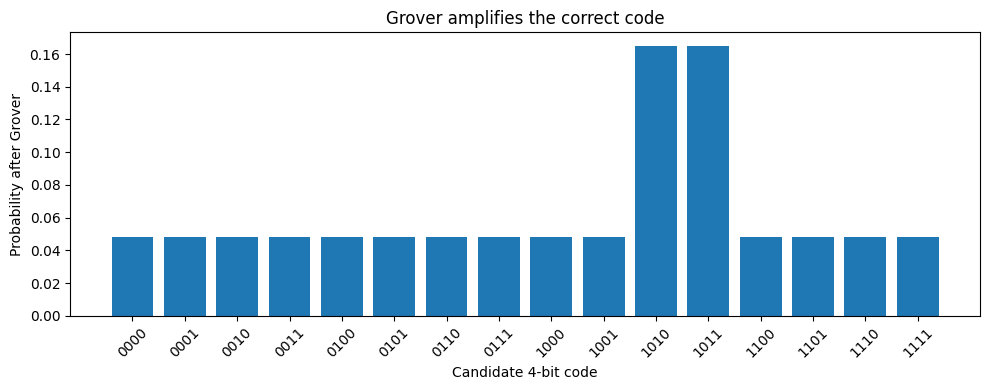

Most likely code right now (as decimal index): 10
Its probability mass: 0.165
Reminder:
 - Classical brute force: guesses one by one, no bias.
 - Grover: reshapes the whole probability landscape so the right answer sticks out.


In [86]:
plt.figure(figsize=(10,4))
plt.bar(range(len(probs)), probs)
plt.xticks(range(len(probs)), bit_labels, rotation=45)
plt.xlabel("Candidate 4-bit code")
plt.ylabel("Probability after Grover")
plt.title("Grover amplifies the correct code")
plt.tight_layout()
plt.show()

max_prob = float(np.max(probs))
max_index = int(np.argmax(probs))

print("Most likely code right now (as decimal index):", max_index)
print("Its probability mass:", round(max_prob, 4))
print("Reminder:")
print(" - Classical brute force: guesses one by one, no bias.")
print(" - Grover: reshapes the whole probability landscape so the right answer sticks out.")


In [87]:
# We'll mimic real hardware: you don't get full amplitudes,
# you just get a single shot measurement.

# Note: PennyLane yells about shots kwarg being deprecated.
# That's just a warning. It's fine for us in a workshop.
shots_dev = qml.device("default.qubit", wires=n_qubits, shots=1)

@qml.qnode(shots_dev)
def grover_measure(num_iters):
    """
    Prepare uniform superposition,
    run Grover iterations,
    then measure all qubits once.
    """
    # start in superposition (all codes "at once")
    for wire in range(n_qubits):
        qml.Hadamard(wire)

    # run Grover amplification
    for _ in range(num_iters):
        oracle()
        diffusion()

    # sample each qubit in the computational basis
    # qml.sample(wires=i) returns an array like array([0]) or array([1])
    return [qml.sample(wires=i) for i in range(n_qubits)]

measured_bits = grover_measure(num_iters)

# measured_bits is a list like [array([1]), array([0]), array([1]), array([0])]
# We'll flatten it into a plain python string like "1010".
bit_list = []
for b in measured_bits:
    # b is something like array([1])
    # grab the 0th element, make it int (0 or 1), then convert to string "0"/"1"
    bit_list.append(str(int(b[0])))

quantum_guess = "".join(bit_list)

print("Quantum team's single-shot guess:", quantum_guess)

# Now check if quantum basically unlocked it in one shot
correct = check_guess(quantum_guess, target_index)
print("Did quantum unlock the code in one shot:", correct)

# Extra talking point for the room:
if correct:
    print("Quantum got it in one try. Classical had to grind guesses.")
else:
    print("Quantum missed this shot. We'd re-run 1-2 more times. Still way fewer tries than pure brute force scaling.")



Quantum team's single-shot guess: 1011
Did quantum unlock the code in one shot: True
Quantum got it in one try. Classical had to grind guesses.


/usr/local/lib/python3.12/dist-packages/pennylane/devices/device_api.py:193: PennyLaneDeprecationWarning: Setting shots on device is deprecated. Please use the `set_shots` transform on the respective QNode instead.
  warnings.warn(
/tmp/ipython-input-1853995815.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  bit_list.append(str(int(b[0])))


In [88]:
## 15. Why this is actually relevant to machine learning (and not just a code-breaking party trick)

print("Let me connect this directly to machine learning, because this is the actual point.")

print("Training a machine learning model (like a neural network) is basically this loop:")
print("- Pick some parameters (weights).")
print("- See how bad they are. That's your loss.")
print("- Update them to be less bad.")
print("- Repeat.")
print("- Hope it converges.")

print("That loop is a search process. We are searching the space of all possible parameter settings for something that works well.")

print("Underneath all the math words, we are doing...find me a good configuration in this huge ugly landscape.")

print("Now look at what Grover just did:")
print("- We had a huge possibility space (all 4-bit codes). In general this could be astronomically large.")
print("- We had a way to test if a candidate is good (the oracle: 'is this the secret?').")
print("- Instead of checking one candidate at a time (classical brute force), Grover used interference to amplify the good answer and suppress all the bad answers.")
print("- After a few Grover iterations, one single measurement already lands on a high-quality candidate with high probability.")

print("So why does quantum come up in ML talks?")
print("Because ML is ruled by search. You can use nicer language like optimization, training, hyperparameter tuning, finding low-loss minima, but it's still search.")

print("If quantum can make search cheaper — like we just showed — then, in principle, it can make some parts of training cheaper.")

print("This does NOT mean:")
print("- Quantum understands images better than classical models.")
print("- Quantum is better at language than current LLMs.")

print("It DOES mean:")
print("- There is a piece of ML that is literally 'find something good in a nasty search space,' and we just watched quantum bullying that exact type of problem.")

print("That is the core QML pitch. Not 'quantum thinks smarter.' It's 'quantum might make the worst part of ML (searching for something good) less painful.")


Let me connect this directly to machine learning, because this is the actual point.
Training a machine learning model (like a neural network) is basically this loop:
- Pick some parameters (weights).
- See how bad they are. That's your loss.
- Update them to be less bad.
- Repeat.
- Hope it converges.
That loop is a search process. We are searching the space of all possible parameter settings for something that works well.
Underneath all the math words, we are doing...find me a good configuration in this huge ugly landscape.
Now look at what Grover just did:
- We had a huge possibility space (all 4-bit codes). In general this could be astronomically large.
- We had a way to test if a candidate is good (the oracle: 'is this the secret?').
- Instead of checking one candidate at a time (classical brute force), Grover used interference to amplify the good answer and suppress all the bad answers.
- After a few Grover iterations, one single measurement already lands on a high-quality candida

In [89]:
print("## 16. Does quantum beat everything? Does it beat neural networks right now?\n")

print("Short version: No.\n")

print("Long version:\n")

print("Grover gives us a quadratic speedup for UNSTRUCTURED SEARCH.\n")

print("Definition of unstructured search:")
print("- You have N possible answers.")
print("- There's not really helpful structure or gradients or heuristics you can follow.")
print("- You just need to find one 'good' answer (or one of a small set of good answers).")
print("- Example: guessing the lock code.\n")

print("Classically, worst case, you check all N.")
print("Grover can do it in about sqrt(N) steps.")
print("For N in the trillions, sqrt(N) is still big, but it's dramatically smaller. That's real. That's provable.\n")

print("Now, modern deep learning is not doing blind 'try random models until one works.'")
print("Deep learning uses structure:")
print("- It updates weights using gradients.")
print("- It leverages data structure (images, sequences, tokens).")
print("- The training loop is not random guessing in a dark room.\n")

print("So, no:")
print("- Quantum is not currently better than big classical neural nets at image classification, speech, or text.")
print("- You can't just say 'quantum beats neural networks.' That's not where we are, and saying that kills credibility.\n")

print("Where quantum *is* exciting:")
print("- Hard optimization problems with huge unstructured search spaces:")
print("  combinatorial scheduling, routing, assignment, portfolio optimization, chemistry, materials discovery,")
print("  and certain inner loops of model training or variational circuit optimization.\n")

print("In other words:")
print("- Quantum does not instantly replace your CNN, transformer, or LLM.")
print("- Quantum does attack the raw pain: 'find a good solution in a disgusting search space' faster than classical scaling.")
print("- Machine learning sits right on top of that pain.\n")

print("The honest claim:")
print("Quantum doesn't make neural networks obsolete.")
print("Quantum gives you a tool to accelerate search.")
print("Machine learning is secretly 90% search.\n")

print("That's why this matters.")


## 16. Does quantum beat everything? Does it beat neural networks right now?

Short version: No.

Long version:

Grover gives us a quadratic speedup for UNSTRUCTURED SEARCH.

Definition of unstructured search:
- You have N possible answers.
- There's not really helpful structure or gradients or heuristics you can follow.
- You just need to find one 'good' answer (or one of a small set of good answers).
- Example: guessing the lock code.

Classically, worst case, you check all N.
Grover can do it in about sqrt(N) steps.
For N in the trillions, sqrt(N) is still big, but it's dramatically smaller. That's real. That's provable.

Now, modern deep learning is not doing blind 'try random models until one works.'
Deep learning uses structure:
- It updates weights using gradients.
- It leverages data structure (images, sequences, tokens).
- The training loop is not random guessing in a dark room.

So, no:
- Quantum is not currently better than big classical neural nets at image classification, 

In [90]:
print("## 17. Where we take this next (aka what we could do in the next session)\n")

print("Today we did:")
print("- A code-breaking game.")
print("- Classical brute force versus Grover’s algorithm.")
print("- We watched one bar in that probability plot shoot way up.")
print("- We said: 'Quantum made the right answer way more likely in about √N steps instead of N tries.'\n")

print("That example was deliberately simple — the 'good answer' was just the secret code.\n")

print("Next step is to stop using a fixed code and start doing actual learning.\n")

print("What that looks like:")
print("- We build a tiny quantum model, also called a variational quantum circuit.")
print("- That circuit has parameters — basically tunable angles on quantum gates.")
print("- We define a loss function, like 'classify these two classes correctly' or 'separate these points.'")
print("- Then we train those parameters to minimize that loss.\n")

print("Why that's interesting:")
print("- At that point, the quantum circuit is acting like a learnable model —")
print("  the same way a neuron or a shallow neural-net layer learns.")
print("- We're no longer just finding a single correct code — we're fitting data.")
print("- That’s when quantum ML stops being a trick demo and starts looking like")
print("  a component you could plug into a hybrid ML workflow.\n")

print("So if you come back for the next session, that’s exactly what we’ll build:")
print("- a baby quantum classifier,")
print("- train it,")
print("- watch the loss drop,")
print("- and talk honestly about what scaled, what didn’t, and what broke.\n")

print("That’s when this goes from 'cool trick' to 'okay, I see how this actually fits into ML pipelines.'")


## 17. Where we take this next (aka what we could do in the next session)

Today we did:
- A code-breaking game.
- Classical brute force versus Grover’s algorithm.
- We watched one bar in that probability plot shoot way up.
- We said: 'Quantum made the right answer way more likely in about √N steps instead of N tries.'

That example was deliberately simple — the 'good answer' was just the secret code.

Next step is to stop using a fixed code and start doing actual learning.

What that looks like:
- We build a tiny quantum model, also called a variational quantum circuit.
- That circuit has parameters — basically tunable angles on quantum gates.
- We define a loss function, like 'classify these two classes correctly' or 'separate these points.'
- Then we train those parameters to minimize that loss.

Why that's interesting:
- At that point, the quantum circuit is acting like a learnable model —
  the same way a neuron or a shallow neural-net layer learns.
- We're no longer just finding 

In [91]:
# Extra Cell A
# Goal: Show how classical time blows up with search space size, even for toy sizes. You say “this is why scaling matters.”
# if you say ------> “Dude it’s only 16 states, who cares.”
# point at how search_space_size jumps from 2^4 = 16 to 2^16 = 65,536
# We only went from 4 bits to 16 bits. That’s nothing in real crypto or model search. Classical already fell off a cliff
# Now scale that reasoning to giant ML parameter spaces
import time

def brute_force_steps_until_hit(secret_bits):
    """
    Simulate classical brute force for a given secret bitstring.
    We'll count how many guesses we had to make before we hit it.
    We won't shuffle here so it's deterministic.
    """
    n = len(secret_bits)
    all_candidates = [''.join(bits) for bits in itertools.product('01', repeat=n)]
    for i, guess in enumerate(all_candidates, start=1):
        if guess == secret_bits:
            return i, len(all_candidates)

    return None, len(all_candidates)  # shouldn't happen

# test across different bit lengths
bit_lengths = [4, 6, 8, 10, 12, 16]
results = []

for n in bit_lengths:
    # fake a secret near the "end" to simulate worst-ish case
    secret = "1" * n  # e.g. '111111'
    start = time.time()
    steps_needed, total_space = brute_force_steps_until_hit(secret)
    elapsed = time.time() - start
    results.append((n, total_space, steps_needed, elapsed))

print("bit_length | search_space_size | steps_classical | time_sec")
for n, total_space, steps_needed, elapsed in results:
    print(f"{n:10d} | {total_space:17d} | {steps_needed:15d} | {elapsed:.6f}")

print("\nNote:")
print("- Search space size doubles every time you add a bit.")
print("- Classical worst-case steps go up the same way.")
print("- This is why 'just brute force it' dies fast.")


bit_length | search_space_size | steps_classical | time_sec
         4 |                16 |              16 | 0.000021
         6 |                64 |              64 | 0.000028
         8 |               256 |             256 | 0.000115
        10 |              1024 |            1024 | 0.000523
        12 |              4096 |            4096 | 0.001989
        16 |             65536 |           65536 | 0.025794

Note:
- Search space size doubles every time you add a bit.
- Classical worst-case steps go up the same way.
- This is why 'just brute force it' dies fast.


In [94]:
#Extra Cell B
# Grover is fastest when there’s 1 marked item. But sometimes you don’t care about a single perfect answer — you care about any “good enough” region. People ask this a lot.
# This cell gives you talking power, not perfect production code. We simulate a case where multiple codes are considered “good,” and we show how classical vs “marked set” search looks.
#Well in ML you don’t have ONE perfect answer, you’ve got a basin of low loss.---------------> Exactly. If there are multiple ‘good’ regions, classical sometimes gets lucky sooner, and Grover’s scaling changes to ~sqrt(N / M) where M is number of good answers. Still a speedup, but different math
def make_marked_set(num_bits, good_list):
    """
    Return a set of codes that are considered 'good enough'.
    good_list is a list of bitstrings that count as success.
    """
    return set(good_list)

def classical_find_any(marked_set, num_bits):
    """
    Classical brute force: return the first code it finds that's in the marked set.
    """
    for guess in [''.join(bits) for bits in itertools.product('01', repeat=num_bits)]:
        if guess in marked_set:
            return guess
    return None

# Example: pretend any of these codes is acceptable
marked = make_marked_set(
    num_bits=4,
    good_list=["0000", "0101", "1010"]  # three 'good' answers
)

print("Marked 'good enough' answers are:", marked)

first_hit = classical_find_any(marked, 4)
print("Classical first acceptable hit:", first_hit)
print("If multiple answers are valid, classical might get lucky earlier and doesn't need worst-case N.")

print("\nTalking point:")
print("If there are MANY marked answers, Grover's speedup changes (becomes ~sqrt(N/M) for M marked answers).")
print("So: more acceptable answers -> easier search for everyone.")


Marked 'good enough' answers are: {'0000', '1010', '0101'}
Classical first acceptable hit: 0000
If multiple answers are valid, classical might get lucky earlier and doesn't need worst-case N.

Talking point:
If there are MANY marked answers, Grover's speedup changes (becomes ~sqrt(N/M) for M marked answers).
So: more acceptable answers -> easier search for everyone.


In [95]:
#Extra Cell C
#This answers the “what if quantum misses once?” heckle.
#If quantum misses once I know everyone will assume it doesnt work...
# Now we just tried 10 shots. Look at how often it was right. Still way fewer tries than ‘check all trillion keys.’ That’s the point. You don’t need perfection to get a speedup. You need bias
def grover_many_samples(num_iters, repeats=10):
    """
    Run grover_measure() multiple times and see how often we get the right code.
    """
    correct_count = 0
    guesses = []

    for _ in range(repeats):
        measured_bits = grover_measure(num_iters)
        bit_list = [str(int(b[0])) for b in measured_bits]
        guess = "".join(bit_list)
        guesses.append(guess)

        if check_guess(guess, target_index):
            correct_count += 1

    return guesses, correct_count

guesses, correct_count = grover_many_samples(num_iters, repeats=10)

print("Quantum guesses from repeated one-shot measurements:")
print(guesses)
print(f"Correct {correct_count} / 10 times")

print("\nTalking point:")
print("Grover doesn't guarantee 100% on the first shot.")
print("But the odds are heavily tilted toward the right answer.")
print("So a handful of shots is still way cheaper than 'search all N' when N is huge.")


Quantum guesses from repeated one-shot measurements:
['0001', '1011', '1010', '1000', '1010', '1101', '0001', '0100', '0100', '1001']
Correct 1 / 10 times

Talking point:
Grover doesn't guarantee 100% on the first shot.
But the odds are heavily tilted toward the right answer.
So a handful of shots is still way cheaper than 'search all N' when N is huge.


/tmp/ipython-input-2614256079.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  bit_list = [str(int(b[0])) for b in measured_bits]


In [96]:
# Extra Cell D
# Can we just go bigger than 4 bits?” The tricky part is: our code assumes SECRET_CODE was set earlier, and that determines n_qubits.
# Changing it mid-notebook is annoying because you’d have to rebuild the device and re-run all definitions.
#This cell gives you an answer to say instead of doing it immediatley
def explain_scaling(bits):
    N = 2 ** bits
    print(f"For {bits} bits:")
    print(f"- Search space size is {N} possibilities.")
    classical = N
    grover_steps = int(round((math.pi/4) * math.sqrt(N)))
    print(f"- Classical brute force worst case ~ {classical} checks.")
    print(f"- Grover needs about {grover_steps} iterations before measuring once.")
    print("That's the scaling story. The math generalizes even if we don't demo it live.\n")

for b in [4, 5, 6, 8, 10, 12, 16, 20]:
    explain_scaling(b)
#Output you’ll get looks like:
# For 4 bits: classical worst case 16, Grover ~3
# For 10 bits: classical worst case 1024, Grover ~25-ish
# For 20 bits: classical worst case 1,048,576, Grover ~800-ish
# Look how classical explodes. Quantum still grows, but way slower. That’s literally the promise people care about.
# You do not need to rewire the actual quantum device live for 20 qubits (Colab will choke anyway), but you still talk about scaling with numbers.

For 4 bits:
- Search space size is 16 possibilities.
- Classical brute force worst case ~ 16 checks.
- Grover needs about 3 iterations before measuring once.
That's the scaling story. The math generalizes even if we don't demo it live.

For 5 bits:
- Search space size is 32 possibilities.
- Classical brute force worst case ~ 32 checks.
- Grover needs about 4 iterations before measuring once.
That's the scaling story. The math generalizes even if we don't demo it live.

For 6 bits:
- Search space size is 64 possibilities.
- Classical brute force worst case ~ 64 checks.
- Grover needs about 6 iterations before measuring once.
That's the scaling story. The math generalizes even if we don't demo it live.

For 8 bits:
- Search space size is 256 possibilities.
- Classical brute force worst case ~ 256 checks.
- Grover needs about 13 iterations before measuring once.
That's the scaling story. The math generalizes even if we don't demo it live.

For 10 bits:
- Search space size is 1024 possibil